<a href="https://colab.research.google.com/github/tcmb1987/ee259-project/blob/main/CS361_EE259_radarsimpy_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 361 and EE 259 Project - Radar Simulator with Optimizer


## Enable GPU Acceleration
To enable GPU in the notebook, select the following menu options:
Runtime -> Change runtime type -> Hardware Accelerator -> GPU

Then run snippet below. If the GPU is enabled, it will give the following output:
'/device:GPU:0'



In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Setup Google Drive Mount and Packages to Correctly Run Radarsimpy


Start with mounting your Stanford Google Drive.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create Ubuntu toolchain, update and install latest libstdc++6 (what was giving us the headache before). Notice, after running the toolchain cell need to click below the prompt and hit 'Enter'. Also, install kaleido since it's what the tutorial uses for plotting.

In [ ]:
!add-apt-repository ppa:ubuntu-toolchain-r/test

 Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

 More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu focal InRelease
Hit:12 http://ppa.launc

In [ ]:
!apt-get update
!apt-get upgrade
!apt-get install libstdc++6
!pip install kaleido

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Calculating upgrade... D

Lastly, import radarsimpy and test if successful by displaying version.

Make sure path is correct, ensure the project folder is saved under 'MyDrive'.

In [ ]:
import sys
FOLDERNAME = 'EE_259_Project' # Folder where simpy is being held in drive, e.g. 'EE_259_Project'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

import radarsimpy
radarsimpy.__version__

'11.1.0'

Confirm Python Version is 3.10, else Radarsimpy will not function

In [ ]:
!python --version

Python 3.10.12


## Packages to Import

In [ ]:
import numpy as np # Numpy for arrays and numerical processing
from radarsimpy import Radar, Transmitter, Receiver # Radarsimpy Transceiver Model

from radarsimpy.simulator import simpy # Python simulator engine
from radarsimpy.simulator import simc # C++ simulator engine

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from IPython.display import Image


# Signal processing helper functions
from scipy import signal
import radarsimpy.processing as proc
from scipy.signal import find_peaks
from numpy.lib.function_base import average

# Optimization Function Definition

Definition of different optimizers.

In [ ]:
# dim = 50
# amps = np.random.randn(dim)
# freqs = np.exp(np.random.randn(dim))

# def f(x,amps=amps, freqs=freqs):
#     return np.sum(amps*np.cos(freqs*x))

# optimization using annealing with momentum
def annealingMomentum(f, x0, n):
    alpha, f0, beta  =  .3, f(x0), .8
    histX = [x0]
    histF = [f0]
    dims = x0.shape
    D = len(dims)
    mom = np.zeros(x0.shape)
    for i in range(n):
        #rand dir
        dx = np.random.rand(*x0.shape)
        newmom = beta * mom + dx * alpha
        fi = f(x0 + newmom)
        histX.append(x0 + newmom)
        histF.append(fi)
        if fi<f0:
            mom = newmom
            f0 = fi
            x0 = x0 + newmom
        else:
            newmom = beta*mom - dx *alpha
            mom = newmom
        histX.append(x0)
        histF.append(f0)
    return x0, histX, histF

# optimization using cross entropy method
def crossentropy(f, x0, n, stdInit, numSamp, numElite):
    mu, f0 = x0, f(x0)
    std = stdInit
    xs, fs, mus, mufs = [], [], [], []
    count = 0
    while count < n-2:
        xs.append(mu+std*np.random.randn(*x0.shape))
        fs.append(f(xs[-1]))
        if len(xs) == numSamp or count== n-2:
            xArr = np.asarray(xs)
            fArr = np.asarray(fs)
            indcs = np.argsort(fArr)
            xBest = xArr[indcs[:numElite]]
            fBest= fArr[indcs[:numElite]]
            mu = np.mean(xBest,0)
            mus.append(mu)
            mufs.append(f(mu))
            std = np.std(xBest,0)
            if fBest[0]<f0:
                f0 = fBest[0]
                x0 = xBest[0]
            xs, fs = [], []
        count+=1

    return x0, mus, mufs

# x0 = np.zeros(50)
# xf, histx, histf = annealingMomentum(f,x0,100)
# print(histf)

Define function to optimize. Based on radar simulation below.

In [ ]:
def f(x):
    # define radar parameters
    frequency = 77e9
    wavelength = 3e8 / frequency
    theta_fov = 140
    angular_res = 1.4
    N = int(theta_fov//angular_res)
    angle = np.linspace(-theta_fov/2, theta_fov/2, N)
    tx_power = 45
    pulses = 9
    num_tx_channels = 9
    num_rx_channels = 16
    cycle_t = 32e-6
    noise_level = 10

    # build radar
    tx_channels = []
    for i in range(num_tx_channels):
      tx_channels.append(dict(location=(0, allLocs[i,0], allLocs[i,1]),
                        azimuth_angle=angle,
                        azimuth_pattern=pattern,
                        elevation_angle=angle,
                        elevation_pattern=pattern,
                        delay=i*cycle_t))

    tx = Transmitter(f=[77e9, 77.256e9],
                    t=17e-6,
                    tx_power=45,
                    prp=288e-6,
                    pulses=9,
                 channels=tx_channels)

    rx_channels = []
    for i in range(num_tx_channels, num_total_channels):
      rx_channels.append(dict(location=(0, allLocs[i,0], allLocs[i,1]),
                        azimuth_angle=angle,
                        azimuth_pattern=pattern,
                        elevation_angle=angle,
                        elevation_pattern=pattern))

    rx = Receiver(fs=15e6,
                  noise_figure=noise_level,
                  rf_gain=20,
                  baseband_gain=50,
                  load_resistor=500,
                  channels=rx_channels)

    radar = Radar(transmitter=tx, receiver=rx)

    # get targets
    target_1 = dict(location=(160, 0, 0), speed=(0, 0, 0), rcs=25, phase=0)
    target_2 = dict(location=(80, -80, 0), speed=(0, 0, 0), rcs=20, phase=0)
    target_3 = dict(location=(30, 20, 0), speed=(0, 0, 0), rcs=8, phase=0)

    targets = [target_1, target_2, target_3]

    # perform DSP on radar signal
    data = simc(radar, targets)
    timestamp = data['timestamp']
    baseband = data['baseband']
    range_window = signal.chebwin(radar.samples_per_pulse, at=60)
    range_profile = proc.range_fft(baseband, range_window)

    # calculate SNR
    s = np.mean(np.abs(range_profile), axis=0)
    s = np.mean(s, axis=0)
    s_peaks,_ = find_peaks(s, np.percentile(s, 97.5))

    total_signal = 0
    for peak in s_peaks:
        total_signal += s[peak]

    average_signal = 20 * np.log10(total_signal / len(s_peaks))

    return average_signal/noise_level

In [ ]:
# allLocs is defined in the Radar Simulator section as the initial antenna locations
x0 = allLocs
n = 100

# x, x_history, f_history = annealingMomentum(f, x0, n)
x, x_history, f_history = crossentropy(f, x0, 50, 1, 20, 25)

In [ ]:
# print(x_history)
print(f_history)

NameError: ignored

## Radar Simulation
Based on the TDM FMCW MIMO [tutorial](https://radarsimx.com/2019/04/07/tdm-mimo-fmcw-radar/). In cell below, currently modifying parameters for TIDEP-01012 cascaded radar initial conditions. Setting up 12 TX antenna positions and characteristics (Thomas @ 6/1/2023 11:00 AM). Facing front of board, lower-left corner is origin. Characteristics referenced and measurements calculated using TIDEP-01012 [design guide](https://www.ti.com/lit/pdf/tiduen5).

In [ ]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

# TIDEP-01012 design parameters, use 77 GHz for freq
frequency = 77e9
wavelength = 3e8 / frequency
theta_fov = 140
angular_res = 1.4
N = int(theta_fov//angular_res)
angle = np.linspace(-theta_fov/2, theta_fov/2, N)
tx_power = 45
pulses = 9
num_tx_channels = 9
num_rx_channels = 16
cycle_t = 32e-6
noise_level = 20

# Beam pattern definition (no changes from tutorial)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

# PCB corner locations
PCB_corners = [[0, 0, 0],
               [0, 0, 34 * wavelength],
               [0, 40 * wavelength, 34 * wavelength],
               [0, 40 * wavelength, 0]]

print(N)

100


Build radar simulator with initial conditions.

In [ ]:
#### 361 ADDITIONS ####
# There are 9 transmit, 16 receive, errbody on x = 0 plane
num_total_channels =  num_tx_channels + num_rx_channels
allLocs = np.zeros((num_total_channels, 2))
# allLocs[:,0] = np.random.rand(25)*40*wavelength
# allLocs[:,1] = np.random.rand(25)*34*wavelength
allLocs[0,:] = np.array([30.5*wavelength, 11*wavelength])
allLocs[9,:] = np.array([7*wavelength, 30*wavelength])

# Define antenna locations for initial conditions according to TIDEP-01012
for i in range(1, num_tx_channels):
    allLocs[i,:] = np.array([allLocs[i-1,0] - 2*wavelength, allLocs[0,1]])
for i in range(num_tx_channels + 1, num_total_channels):
    if i == num_tx_channels + 6:
        allLocs[i,:] = np.array([allLocs[i-1,0] + 4*wavelength, allLocs[0,1]])
    elif i == num_tx_channels + 9:
        allLocs[i,:] = np.array([allLocs[i-1,0] + 16*wavelength, allLocs[0,1]])
    else:
        allLocs[i,:] = np.array([allLocs[i-1,0] + 0.5*wavelength, allLocs[0,1]])

# Build Transmitter
tx_channels = []
for i in range(9):
  tx_channels.append(dict(location=(0, allLocs[i,0], allLocs[i,1]),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=i*cycle_t))

tx = Transmitter(f=[77e9, 77.256e9],
                 t=17e-6,
                 tx_power=45,
                 prp=288e-6,
                 pulses=9,
                 channels=tx_channels)

# Build Receiver
rx_channels = []
for i in range(9,25):
  rx_channels.append(dict(location=(0, allLocs[i,0], allLocs[i,1]),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern))

rx = Receiver(fs=15e6,
              noise_figure=noise_level,
              rf_gain=20,
              baseband_gain=50,
              load_resistor=500,
              channels=rx_channels)

radar = Radar(transmitter=tx, receiver=rx)

In [ ]:
print(allLocs)

[[0.11883117 0.04285714]
 [0.11103896 0.04285714]
 [0.10324675 0.04285714]
 [0.09545455 0.04285714]
 [0.08766234 0.04285714]
 [0.07987013 0.04285714]
 [0.07207792 0.04285714]
 [0.06428571 0.04285714]
 [0.05649351 0.04285714]
 [0.02727273 0.11688312]
 [0.02922078 0.04285714]
 [0.03116883 0.04285714]
 [0.03311688 0.04285714]
 [0.03506494 0.04285714]
 [0.03701299 0.04285714]
 [0.0525974  0.04285714]
 [0.05454545 0.04285714]
 [0.05649351 0.04285714]
 [0.11883117 0.04285714]
 [0.12077922 0.04285714]
 [0.12272727 0.04285714]
 [0.12467532 0.04285714]
 [0.12662338 0.04285714]
 [0.12857143 0.04285714]
 [0.13051948 0.04285714]]


Build a target list.

In [ ]:
target_1 = dict(location=(160, 0, 0), speed=(0, 0, 0), rcs=25, phase=0)
target_2 = dict(location=(80, -80, 0), speed=(0, 0, 0), rcs=20, phase=0)
target_3 = dict(location=(30, 20, 0), speed=(0, 0, 0), rcs=8, phase=0)

targets = [target_1, target_2, target_3]

Initialize RadarSimPy Pythong engine. If this cell is not running, make sure the Setup section ran, then restart runtime, re-import radarsimpy and try running again.

In [ ]:
# Python engine
from radarsimpy.simulator import simpy

data = simpy(radar, targets)
timestamp = data['timestamp']
baseband = data['baseband']

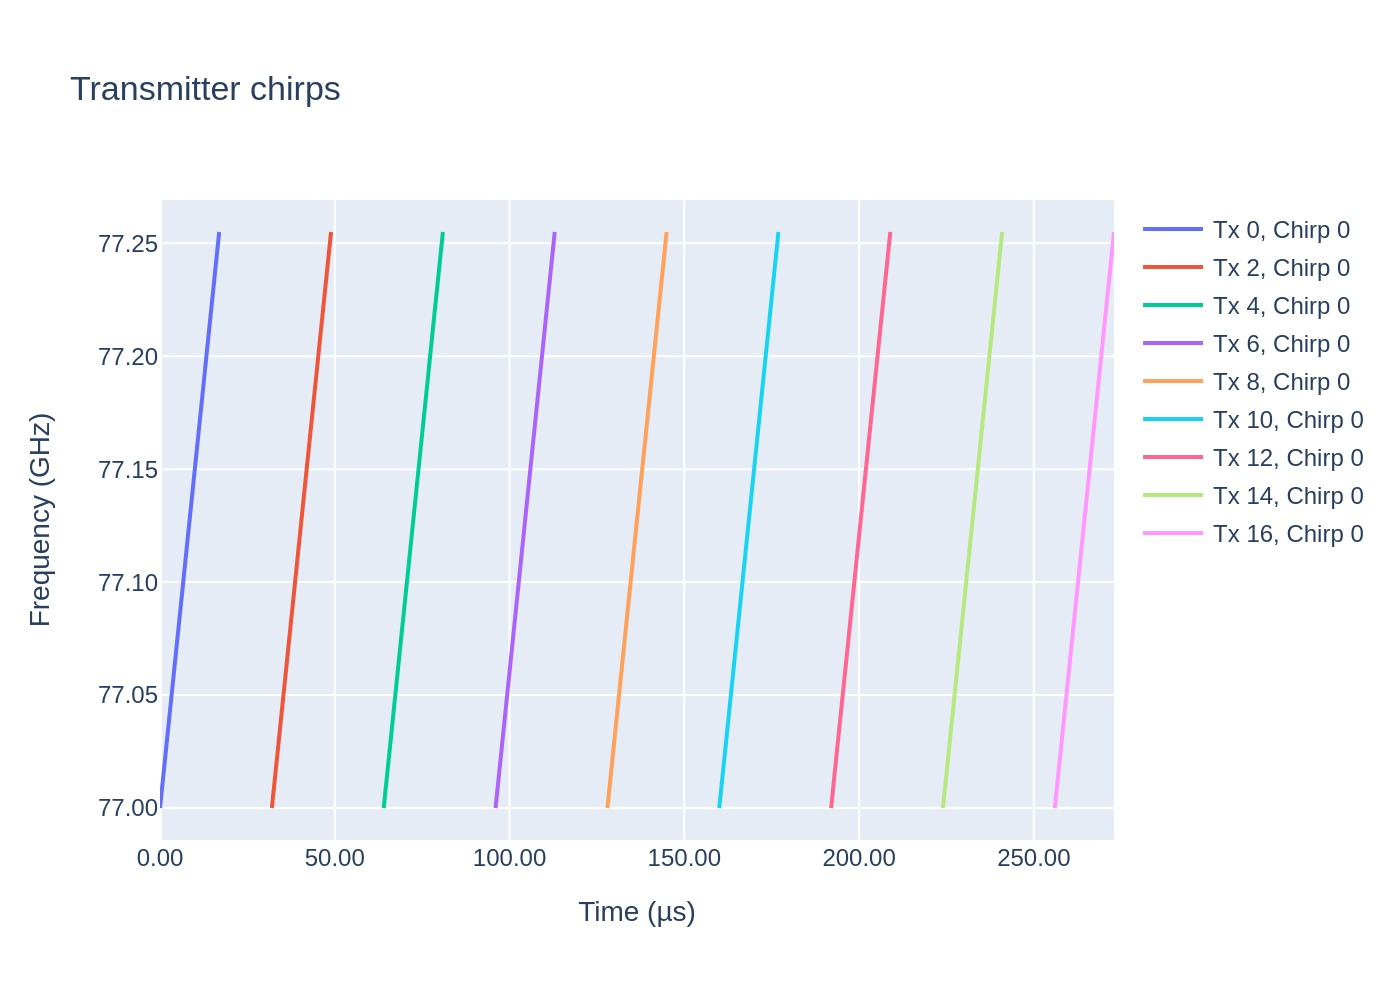

In [ ]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()

for idx in range(0, 1):
    for ch_idx in range(0, 144, 16):
        fig.add_trace(go.Scatter(
            x=timestamp[ch_idx, idx, :] * 1e6,
            y=np.linspace(
                radar.transmitter.fc_vect[0] - radar.transmitter.bandwidth / 2,
                radar.transmitter.fc_vect[0] + radar.transmitter.bandwidth / 2,
                radar.samples_per_pulse,
                endpoint=False,
            ) / 1e9,
            name='Tx ' + str(int(ch_idx / 8)) + ', Chirp ' + str(idx),
        ))


fig.update_layout(
    title='Transmitter chirps',
    yaxis=dict(tickformat='.2f', title='Frequency (GHz)'),
    xaxis=dict(tickformat='.2f', title='Time (µs)'),
)

# fig.show()
# display(SVG(fig.to_image(format='svg', scale=1)))
Image(fig.to_image(format="jpg", scale=2))

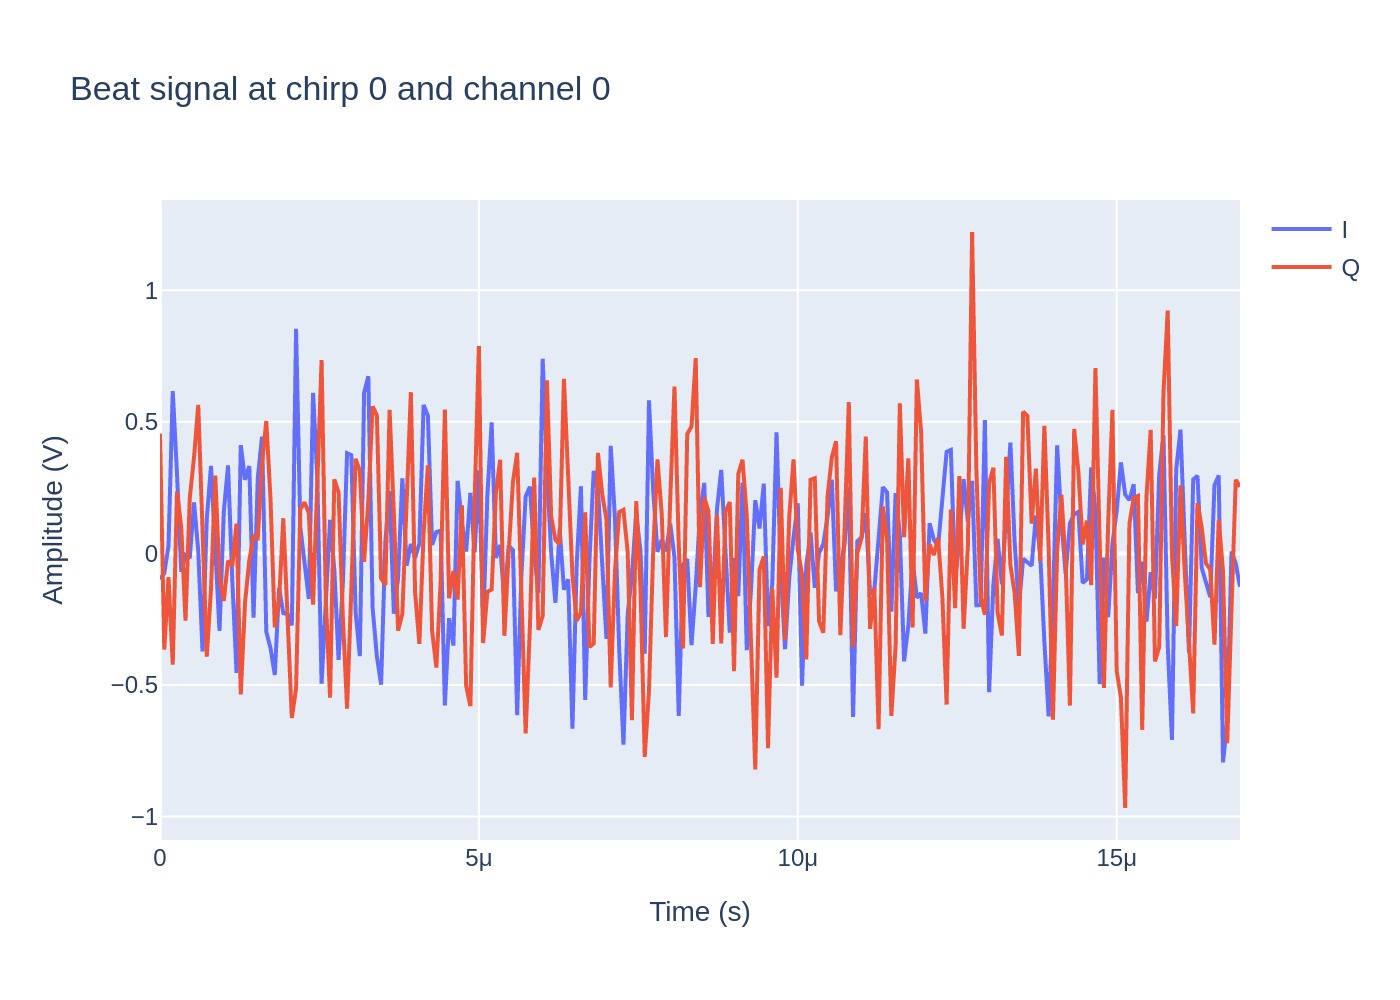

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.real(baseband[0, 0, :]),
    name='I',
))
fig.add_trace(go.Scatter(
    x=timestamp[0, 0, :],
    y=np.imag(baseband[0, 0, :]),
    name='Q',
))

fig.update_layout(
    title='Beat signal at chirp 0 and channel 0',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

# fig.show()
# display(SVG(fig.to_image(format='svg', scale=1)))
Image(fig.to_image(format="jpg", scale=2))

In [ ]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.range_fft(baseband, range_window)

In [ ]:
from scipy.signal import find_peaks

# Get MIMO signal by averaging receiver returns
s = np.mean(np.abs(range_profile), axis=0)
s = np.mean(s, axis=0)
s_peaks,_ = find_peaks(s, np.percentile(s, 97.5))

# Calculate SNR
SNR = 0
for peak in s_peaks:
    SNR += s[peak]

SNR = 20 * np.log10(SNR / len(s_peaks)) / noise_level
SNR

1.2518641076673238

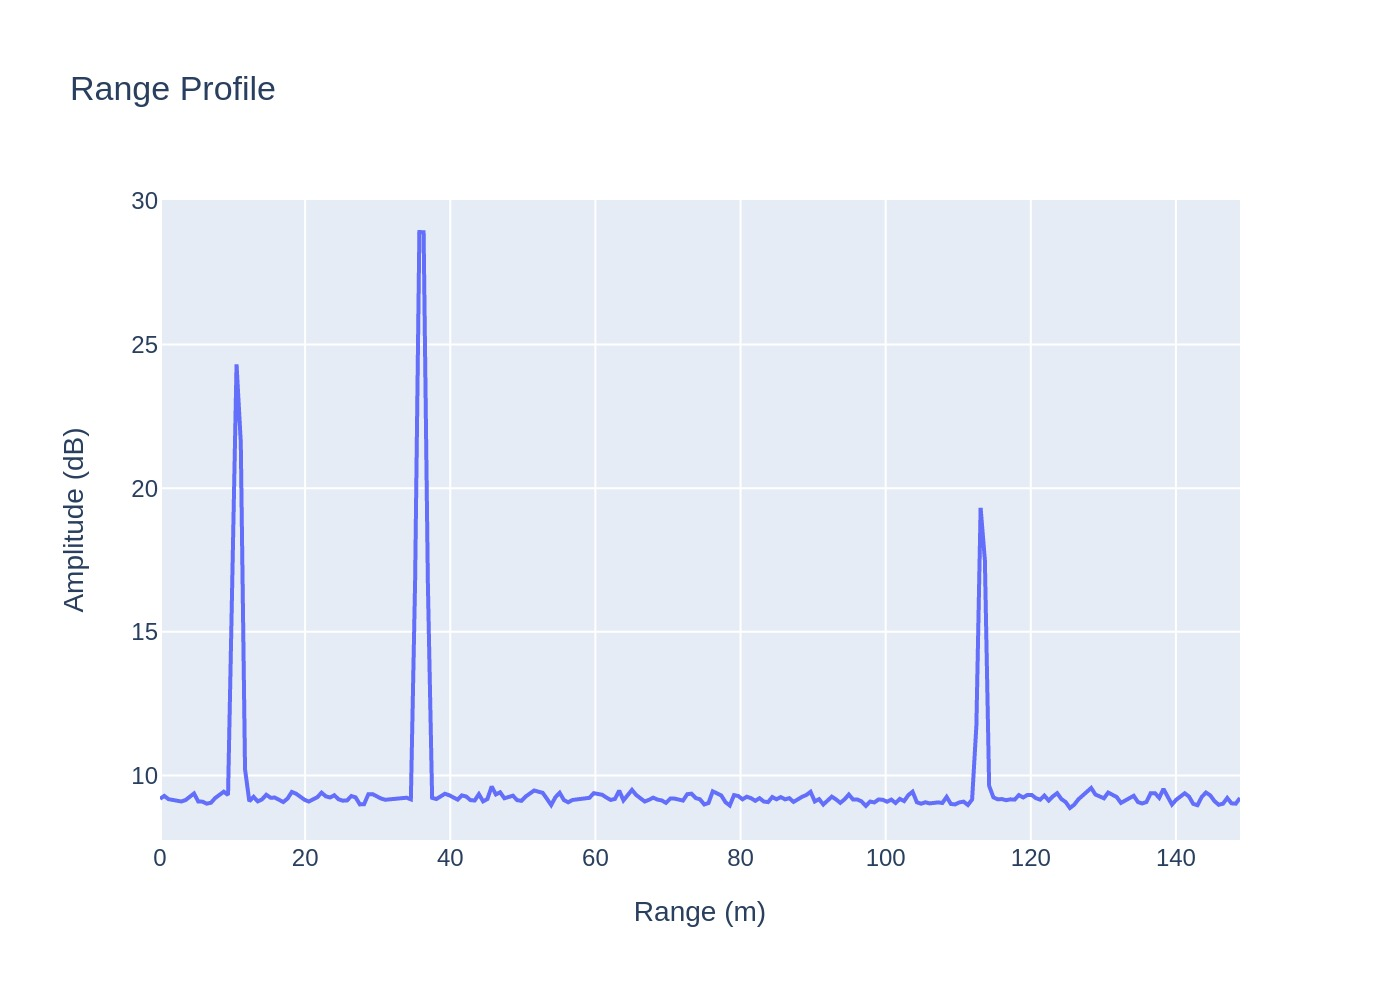

In [ ]:
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)
range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=range_axis,
#     y=20 * np.log10(np.abs(range_profile[0, 0, :])),
#     name='Channel 1'
# ))
# fig.add_trace(go.Scatter(
#     x=range_axis,
#     y=20 * np.log10(np.abs(range_profile[8, 0, :])),
#     name='Channel 2'
# ))
fig.add_trace(go.Scatter(
    x=range_axis,
    y=20 * np.log10(np.abs(s)),
    name='Channel 3'
))
# fig.add_trace(go.Scatter(
#     x=range_axis,
#     y=20 * np.log10(np.abs(range_profile[24, 0, :])),
#     name='Channel 4'
# ))

fig.update_layout(
    title='Range Profile',
    xaxis=dict(title='Range (m)'),
    yaxis=dict(title='Amplitude (dB)'),
)

# fig.show()
# display(SVG(fig.to_image(format='svg', scale=1)))
Image(fig.to_image(format="jpg", scale=2))

In [ ]:
azimuth = np.arange(-90, 90, 1)

array_loc_x = np.zeros((1, len(radar.virtual_array)))
for va_idx, va in enumerate(radar.virtual_array):
    array_loc_x[0, va_idx] = va[1] * radar.transmitter.fc_vect[0] / 3e8

azimuth_grid, array_loc_grid = np.meshgrid(azimuth, array_loc_x)

A = np.transpose(
    np.exp(1j * 2 * np.pi * array_loc_grid *
           np.sin(azimuth_grid / 180 * np.pi)))

bf_window = np.transpose(
    np.array([signal.chebwin(len(radar.virtual_array), at=50)]))
AF = np.matmul(
    A, range_profile[:, 0, :] *
    np.repeat(bf_window, radar.samples_per_pulse, axis=1))

map_2d = proc.get_polar_image(np.transpose(AF), radar.samples_per_pulse, 180,
                              180)

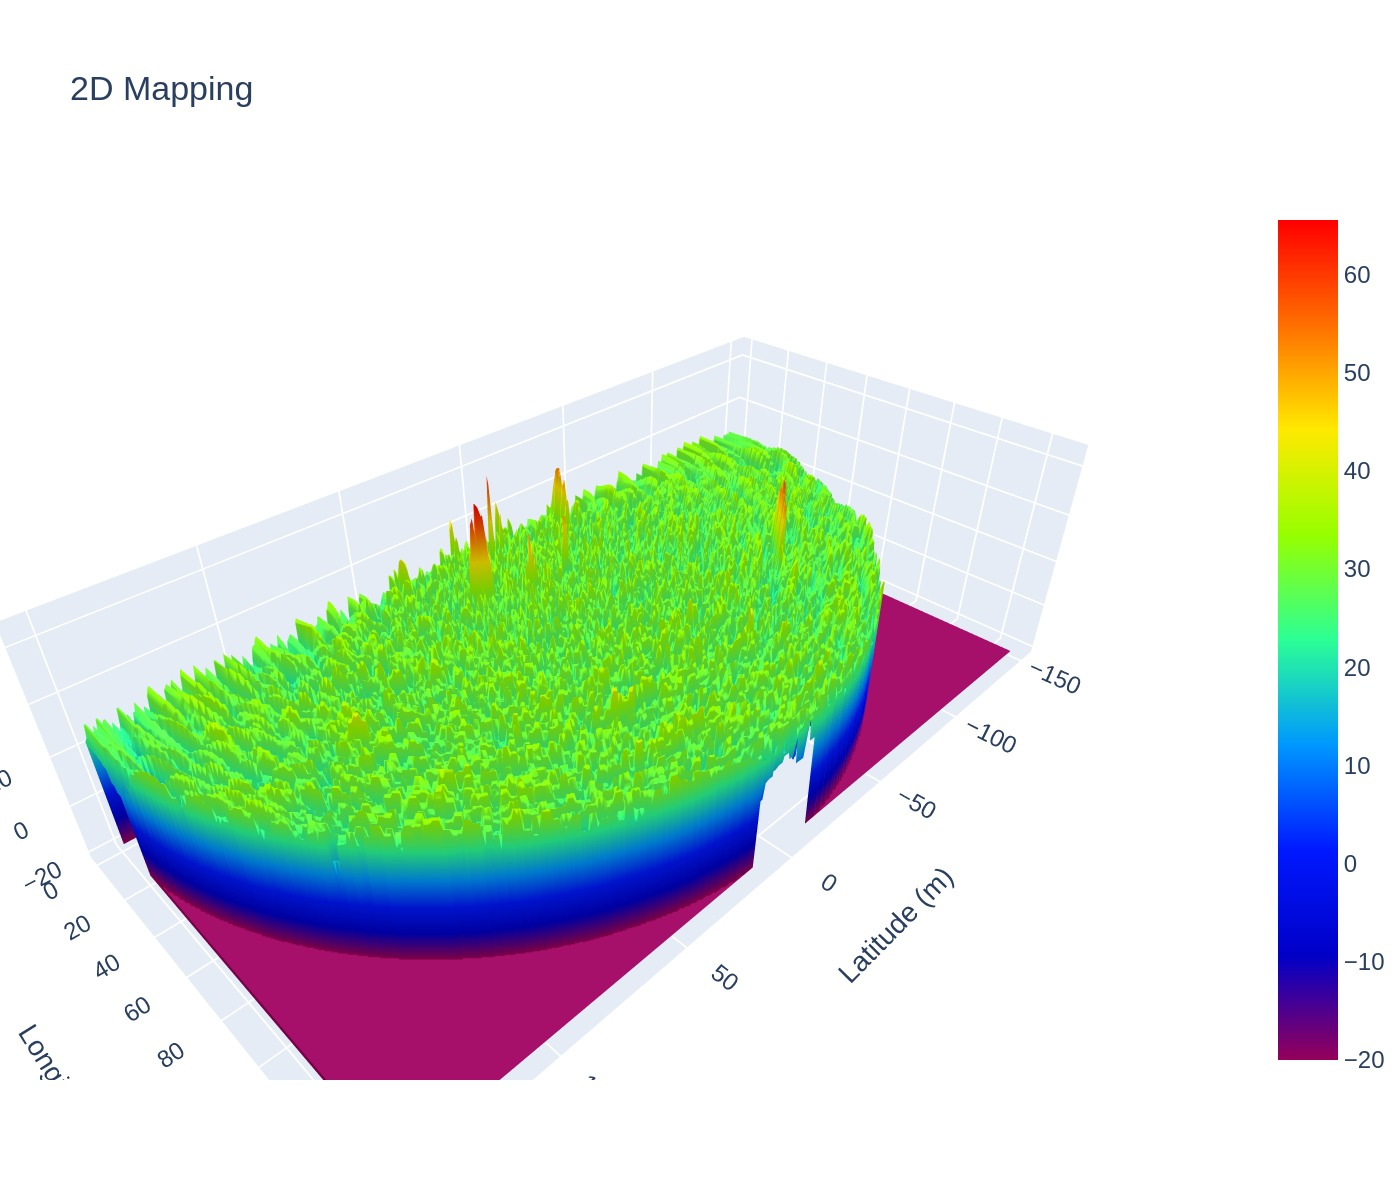

In [ ]:
range_axis_la = np.linspace(0,
                            max_range,
                            radar.samples_per_pulse,
                            endpoint=False)
range_axis_lo = np.linspace(-max_range,
                            max_range,
                            radar.samples_per_pulse * 2,
                            endpoint=False)

fig = go.Figure()
fig.add_trace(go.Surface(x=range_axis_lo,
                         y=range_axis_la,
                         z=20 * np.log10(np.abs(map_2d) + 0.1),
                         colorscale='Rainbow'))

fig.update_layout(
    title='2D Mapping',
    height=600,
    scene=dict(
        xaxis=dict(title='Latitude (m)'),
        yaxis=dict(title='Longitude (m)'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='data',
    ),
    margin=dict(l=0, r=0, b=60, t=100),
)

# fig.show()
# display(SVG(fig.to_image(format='svg', scale=1)))
Image(fig.to_image(format="jpg", scale=2))

#Dana's Script

In [ ]:
print(tx.pulses)

9


theta_hat (degrees): [-68.24634656 -34.34237996 -26.15866388 -22.35908142 -15.05219207
  16.80584551  28.2045929   36.38830898  45.74112735  51.00208768
  56.84759916  63.86221294]


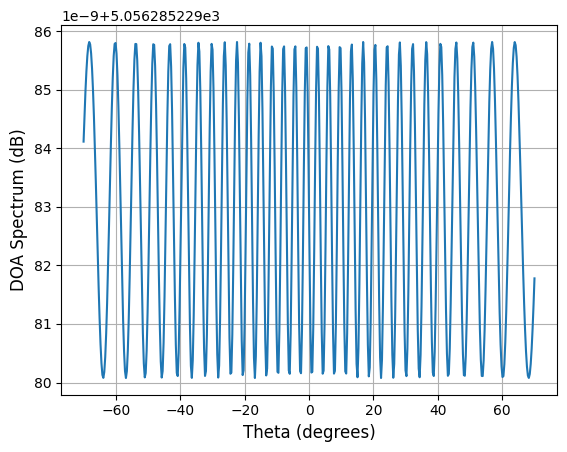

In [ ]:
# MY CHANGES
doppler_window = signal.chebwin(tx.pulses, at=60) # is 60 correct?
range_dopp_prof = proc.range_doppler_fft(baseband, range_window, doppler_window)

# Get MIMO signal by averaging receiver returns
P = range_dopp_prof.shape[0]
doppler_indices = range_dopp_prof.shape[1]
range_indices = range_dopp_prof.shape[2]
avg_prof = np.mean(np.abs(range_dopp_prof), axis=0) # avg along number of channels- then get peaks
# flatten, find doppler + range peak indices for targets (should be 3)
flattened_avg_prof = avg_prof.flatten()
# indices of peaks in flattened 1d array
s_peaks,_ = find_peaks(flattened_avg_prof, np.percentile(flattened_avg_prof, 99.85))  # issue!! what do we set to to find peaks?
# get 2d indices of peaks- should return a list of 2 (num axis) length-3 (num targets) tuples
s_2d_peaks = np.unravel_index(s_peaks,(doppler_indices,range_indices))
doppler_pk_idx = s_2d_peaks[0]
range_pk_idx = s_2d_peaks[1]

# initialize empty array to fill with rx signal about targets (like s vector from hw2q3)
s_vec = np.empty(P,dtype='complex128')
for pk in range(len(targets)):
  di = doppler_pk_idx[pk]
  ri = range_pk_idx[pk]
  s_vec += np.array(range_dopp_prof[:,di,ri])

my_fov = 140*np.pi/180
num_doa = 480
doa_grid = np.linspace(-my_fov/2,my_fov/2,num_doa)

A = np.zeros((P,num_doa),dtype=complex)

# first 9 are tx, second 16 are rx
real_array_elem_pos=np.linalg.norm(allLocs,axis=1)
real_tx_pos = real_array_elem_pos[:num_tx_channels]
real_rx_pos = real_array_elem_pos[num_tx_channels:]

virtual_array_elem_pos = np.empty(P)
idx = 0
for tx_elem in range(num_tx_channels):
  for rx_elem in range(num_rx_channels):
    virtual_array_elem_pos[idx] = real_tx_pos[tx_elem]+real_rx_pos[rx_elem]
    idx += 1

# Compute DOA spectrum, number of targets and respective DOA estimates

for i in range(len(doa_grid)):
    ai = np.array(np.exp(-2*1j*np.pi/wavelength*np.sin(doa_grid[i])*np.array(virtual_array_elem_pos)))
    A[:,i] = ai

d_multi = np.absolute(np.matmul(np.conjugate(np.transpose(A)),s_vec))

d_peaks,_ = find_peaks(d_multi, np.percentile(d_multi, 97.5))
theta_hat= doa_grid[d_peaks]*180/np.pi
print("theta_hat (degrees): "+str(theta_hat))

# plot the DOA Spectrum
import matplotlib
import matplotlib.pyplot as plt
fig1, axs1 = plt.subplots(1, 1)
axs1.plot(doa_grid*180/np.pi, 20*np.log10(d_multi))
axs1.set_xlabel('Theta (degrees)', fontsize=12)
axs1.set_ylabel('DOA Spectrum (dB)', fontsize=12)
axs1.grid(visible=True)
plt.show()